# Generando un tren de pulsos de radar pulsado

Un radar pulsado es aquel capaz de medir tanto rango (distancia) como velocidad, haciendo uso de la transmisión de pulsos muy cortos de duración τ y un periodo de escucha mayor Τ para luego leer el reflejo del mismo en alguna superficie. La distancia al objetivo se determina por el tiempo de ida y vuelta de la señal (en el caso estacionario) generando un Δ$t$, lo que nos permite utilizar la siguiente fómula:
 ### <center> $R = \frac{\Delta t*c}{2}$            
  Donde $R$ es el rango y $c$ es la velocidad de propagación de la onda, que al ser electromagnética corresponde a la velocidad de la luz. Con esta información y midiendo el $\Delta t$, podemos calcular una estimación del rango.

In [1]:
import adi
import time
import timeit
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import threading
from commpy.filters import rrcosfilter
from sk_dsp_comm import digitalcom as dc
import scipy.signal as signal
from scipy.fftpack import fftfreq
from scipy.linalg import bandwidth

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = "ip:192.168.1.36"
SamplingRate     = 6e6        # Sample rate RX and TX paths[Samples/Sec]
Loopback         = 1          # 0=Disabled, 1=Digital, 2=RF

TxLOFreq         = 918e6         # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten          = 0           # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
TxRfBw           = 6e6           # Bandwidth of front-end analog filter of TX path [Hz]

RxLOFreq         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes = "slow_attack" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 0             # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz]
RxBufferSize     = 2**20-1

Definimos variables como el PRI (pulse repetition interval) y su inversa, PRF (pulse repetition frequency). Por otro lado, determinamos la frecuencia de sampling y de transmisión dentro del pulso. El valor del PRI nos dará el rango máximo calculable por nuestro radar, ya que, nuestro pulso debe ser transmitido y recibido antes de volver a transmitir el segundo pulso. Es por esto que la máxima distancia calculable es:
  
$Max Range = \frac{c}{2}*PRI $.

En nuestro caso, la distancia máxima es de 150000 [m] o 150 [km] para un PRI de 0.001 [s] y una PRF de 1[kHz].

In [3]:
PRI = 0.001 #Se trata de un valor arbitrario, intervalo cada cuánto se repite el pulso (entre el inicio de un pulso y su antecesor)
PRF = 1/PRI #cantidad de pulsos por unidad de tiempo
potencia_señal = 1

pulses = 100 #cantidad de pulsos del radar

sample_f = SamplingRate
step = 1/SamplingRate #paso entre las muestras
f1 = 500e3
samples = pulses*int(PRI/step) # PRI/step cantidad de muestras que necesito para un PRI.

En esta porción de código calculamos la cantidad de $samples$ que vamos a utilizar, se obtiene de la división entre el intervalo de la repetición de pulsos y el paso entre las muestras, esto nos da la cantidad de muestras por pulso, luego, al multiplicarlo por la cantidad de pulsos del radar obtenemos la cantidad de muestras.

En las siguientes celdas generamos nuestra señal a transmitir ,nuestro vector de tiempo y se realiza la configuración de la SDR haciendo uso de la libreria adi. Modulamos el tren de pulsos con la siguiente función senoidal

\begin{equation}
    Tx_I = \sin(2* \pi * f_1 * t)
\end{equation}

\begin{equation}
    Tx_Q = \sin(2* \pi * f_1 * t)
\end{equation}

\begin{equation}
    Tx = Tx_I + jTx_Q = \sin(2* \pi * f_1 * t) + j * \sin(2* \pi * f_1 * t)
\end{equation}


In [4]:
t = np.linspace(0,(samples-1)*step,samples) #Genera el array de valores de tiempo (600.000 valores separados cada <step> unidades de tiempo)
pulse_length = 0.000005 #[s] => 0.5 duración del pulso en segundos
Tx_I = 20*np.sin(2*np.pi*f1*t) + 20
Tx_Q = 20*np.sin(2*np.pi*f1*t + np.pi/2) + 20
global zeros
zeros = np.zeros(len(t))  # arreglo completo
ones = np.ones(int(pulse_length*SamplingRate)) # señal continua de duracion pulse_length

for i in range(0,len(Tx_I),int(PRI*SamplingRate)):
      zeros[i:i+len(ones)] = ones #Cada un PRI, hacemos a la función zeros igual a 1 durante un tiempo <pulse_length> (es decir tenemos un tren de pulsos)
        
zerosOG = zeros

/home/jupyter-user_comdig23_3/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


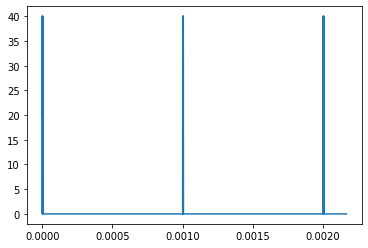

In [5]:
Tx_I = Tx_I * zeros # parte real de la señal
Tx_Q = Tx_Q * zeros #parte imaginaria
Tx = Tx_I + 1j * Tx_Q #señal completa

plt.plot(t[:13000],Tx[:13000])

In [6]:
#-----------------------------------SDR Configurations-------------------------------
sdr             = adi.Pluto(Uri)
sdr.sample_rate = SamplingRate
sdr.loopback    = Loopback
#Tx:
sdr.tx_lo                 = int(TxLOFreq)
sdr.tx_hardwaregain_chan0 = TxAtten
sdr.tx_rf_bandwidth       = int(TxRfBw)
sdr.tx_buffer_size        = samples
sdr.tx_cyclic_buffer      = True
# Rx:
sdr.rx_lo                   = int(RxLOFreq)
sdr.gain_control_mode_chan0 = GainControlModes
sdr.rx_rf_bandwidth         = int(RxRfBw)
sdr.rx_cyclic_buffer        = True
sdr.rx_buffer_size          = RxBufferSize
sdr.rx_enabled_channels = [0]

Tramisión y Recepción

In [7]:
Loopback        = 1  
sdr.loopback    = Loopback
sdr.rx_destroy_buffer()
sdr.tx_destroy_buffer()
global trim
trim = 0
global picture
global rxSignal
global rxSignalPic
global zeros
global zerosPic
global rxTime
picture = False

# Función para la transmisión en un hilo
def transmitir():
        sdr.tx(Tx * ((2**15-1)))        
# Función para la recepción en un hilo
def recibir1():
    global rxSignal
    global rxTime
    rxSignal = sdr.rx() / ((2**15-1))  
    rxTime = time.time()
        
stimationDelay = []
lenght = 1000

for l in range(lenght): 
    
    sdr.rx_destroy_buffer()
    sdr.tx_destroy_buffer()
    # Crea los hilos
    thread_tx = threading.Thread(target=transmitir)
    thread_rx1 = threading.Thread(target=recibir1)

    # Inicia los hilos
    thread_rx1.start()
    thread_tx.start()

    # Espera a que los hilos terminen 
    
    thread_rx1.join()
    thread_tx.join()


    trim = np.nonzero(rxSignal)[0][0]
    print(trim/SamplingRate)
    stimationDelay.append(trim/SamplingRate)
    print(l)
       



La media es: 0.03996603733333333
Varianza: 9.499449008310624e-05
Desviación Estándar: 0.009746511687937703


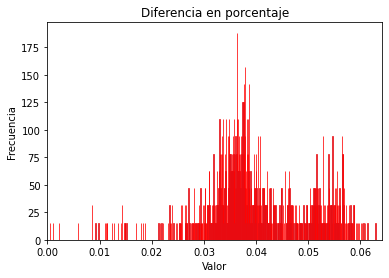

<Figure size 1800x1200 with 0 Axes>

In [11]:

print("La media es: " + str(np.mean(stimationDelay)))
varianza = np.var(stimationDelay)

# Calcula la desviación estándar
desviacion_estandar = np.std(stimationDelay)

print(f'Varianza: {varianza}')
print(f'Desviación Estándar: {desviacion_estandar}')

plt.hist(stimationDelay, bins=len(stimationDelay), density=True, alpha=0.75, edgecolor='red')

# Personalizar el gráfico
plt.title('Diferencia en porcentaje')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.xlim(0,max(stimationDelay))
# Ajustar la resolución
plt.figure(dpi=300)

# Mostrar el histograma
plt.show()